In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import random
import math
import statistics
import os 

# %matplotlib inline
%matplotlib notebook
# from ipywidgets import interactive, interact

# Add latex fonts if availabe (may need to change path of latex install)
if os.path.isdir("/usr/local/texlive/2020/bin"):
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2020/bin/x86_64-darwin'
    rc('text', usetex='True')
    rc('font', family='serif', serif = 'Helvetica')
    params= {'text.latex.preamble' : [r'\usepackage{amsfonts}']}
    plt.rcParams.update(params)
    
if not os.path.exists('./plots'):
    os.makedirs('./plots')

/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
# User Parameters
num_bins = 4
lambda_val = 30
x_min = 10
x_max = 100
alpha_pmf_val_est = np.array([2, 5.5, 20, 25]) # a vector
alpha_pmf_wt_est = np.ones(num_bins)/num_bins # p vector

# Facility Parameters
T = 100 # hrs
num_t_samples = 500
R_ell_A = np.array([15, 30 , 35])
V_ell_A = np.array([.15, .25, .32])

R_ell_B = np.array([15, 30 , 35])
V_ell_B = np.array([.05, .25, .33])

In [4]:
def compute_choice_prob(xj, alphaj, V_ell, R_ell):
    samples = len(xj)
    choices = compute_choice(xj, alphaj, V_ell, R_ell)
    prob = np.zeros((len(V_ell), ))
    for i in range(0, len(V_ell)):
        prob[i] = (choices == i).sum()/samples
    
    return prob

def compute_choice(xj, alphaj, V_ell, R_ell):
    samples = len(xj)
    g = np.zeros((len(V_ell), len(xj)))
    for i in range(0, len(V_ell)):
        g[i] = np.multiply(xj, V_ell[i]) + np.multiply(alphaj, np.divide(xj, R_ell[i]))

    choices = np.argmin(g, axis=0)
    
    return choices 

def compute_expectation_of_r(prob_r, R_ell):
    exp = 0
    for i in range(0, len(R_ell)):
        exp += prob_r[i]*R_ell[i]
    
    return exp 

def compute_expectation_of_1_r(prob_r, R_ell):
    exp = 0
    for i in range(0, len(R_ell)):
        exp += prob_r[i]*(1/R_ell[i])
    
    return exp 

def compute_expectation_of_x(x_min, x_max):
    return (x_max**2 - x_min**2)/(2*(x_max - x_min))

# print("PMF of R: ", prob_r, 
#       "E[r]: ", exp_r,
#       "E[1/r]: ", exp_1_r,
#       "1/E[r]: ", 1/exp_r,
#        "E[x]: ", exp_x)

In [5]:
# eta_t = []
def run_monte_carlo(T, lambda_val, alpha_vals, alpha_probs, V_ell, R_ell, mcruns=5000):
    mc_runs = 1
#     Q_mc = []
#     Q_prod_mc = []
    for i in range(mc_runs):
        time_for_plot = np.linspace(0, T, num_t_samples)
        users_arrived = np.random.poisson(lambda_val*T)
        times_of_arrivals = np.sort(T*np.random.rand(users_arrived))

        # Get users arriving
        xj = np.random.uniform(x_min, x_max, users_arrived)
        alphaj = np.random.choice(alpha_vals, p=alpha_probs, size=users_arrived)

        prob_r = compute_choice_prob(xj, alphaj, V_ell, R_ell)
        exp_r = compute_expectation_of_r(prob_r, R_ell)
        exp_1_r = compute_expectation_of_1_r(prob_r, R_ell)
        exp_x = compute_expectation_of_x(x_min, x_max)

        print("Run: ", i)
        choices = compute_choice(xj, alphaj, V_ell, R_ell)

        
        times_of_departures = []
        for i in range(len(times_of_arrivals)):
            times_of_departures.append(times_of_arrivals[i] + xj[i]/R_ell[choices[i]])

        times_of_departures = np.array(times_of_departures)
#         print(times_of_arrivals, times_of_departures)

        active_users = []
        total_charge_rate = []
        for t in time_for_plot:
            logic = (times_of_arrivals <= t) & (times_of_departures >= t)
            temp = logic * (choices + 1)
            temp = temp[temp > 0] - 1
        #     print(np.sum(np.array(R_ell)[temp]))
            total_charge_rate.append(np.sum(np.array(R_ell)[temp]))
            active_users.append(np.sum(logic))
#         print(len(active_users), active_users)
    
    return active_users, time_for_plot
eta_A, time_A = run_monte_carlo(T, lambda_val, alpha_pmf_val_est, alpha_pmf_wt_est, V_ell_A, R_ell_A)
eta_B, time_B = run_monte_carlo(T, lambda_val, alpha_pmf_val_est, alpha_pmf_wt_est, V_ell_B, R_ell_B)



Run:  0
Run:  0


<IPython.core.display.Javascript object>


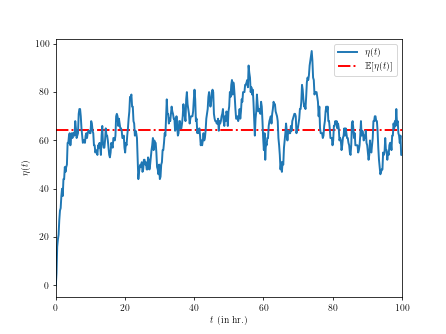

In [6]:
fig, ax = plt.subplots(1,1)
val =  ax.plot(time_A, eta_A, linewidth=2,label=r'$\eta(t)$')
# ax.step(time_A[::10], eta_A[::10])
# ax.plot(time_B, eta_B, linewidth=2)

ax.hlines(np.mean(eta_A), 0, T, linewidth=2, linestyle="-.", color="red",label=r'$\mathbb{E}[\eta(t)]$')
# ax.hlines(np.mean(eta_B), 0, T, linewidth=2, linestyle="-.", color="red")
ax.legend()
ax.set_xlabel(r'$t$ (in hr.)')
ax.set_ylabel(r'$\eta(t)$')
ax.set_xlim([0, T])

x = val[0].get_xdata()
y = val[0].get_ydata()
np.savetxt("etaA" + ".txt", np.c_[x,y])

<IPython.core.display.Javascript object>


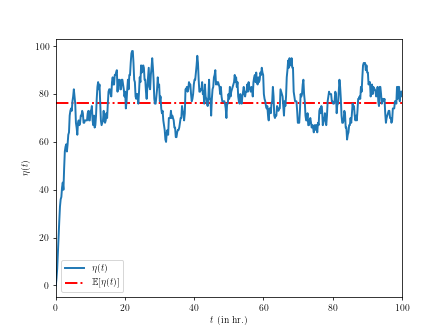

In [7]:
fig, ax = plt.subplots(1,1)
val =  ax.plot(time_B, eta_B, linewidth=2,label=r'$\eta(t)$')
# ax.step(time_A[::10], eta_A[::10])
# ax.plot(time_B, eta_B, linewidth=2)

ax.hlines(np.mean(eta_B), 0, T, linewidth=2, linestyle="-.", color="red",label=r'$\mathbb{E}[\eta(t)]$')
# ax.hlines(np.mean(eta_B), 0, T, linewidth=2, linestyle="-.", color="red")
ax.legend()
ax.set_xlabel(r'$t$ (in hr.)')
ax.set_ylabel(r'$\eta(t)$')
ax.set_xlim([0, T])

x = val[0].get_xdata()
y = val[0].get_ydata()
np.savetxt("etaB" + ".txt", np.c_[x,y])

In [8]:
print(np.mean(eta_A), np.mean(eta_B))

64.246 76.302
